In [1]:
import matplotlib.pyplot as plt
import h5py
import numpy as np
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

import icomo

plt.rcParams.update({'font.size': 8})

In [2]:
def bootstrap_confidence_interval(data, n=1000, func=np.mean, alpha=0.05):
    resamples = np.random.choice(data.dropna(), size=(n, len(data.dropna())), replace=True)
    perc = np.percentile([func(r) for r in resamples], [100*alpha/2, 100*(1-alpha/2)])
    return [func(data.dropna()) - perc[0], perc[1] - func(data.dropna())]

def percentile_confidence_interval(data, alpha=0.05):
    perc = np.percentile(data.dropna(), [100*alpha/2, 100*(1-alpha/2)])
    return [data.mean() - perc[0], perc[1] - data.mean()]

# System definition

In [3]:
# standard parameters
_RATE_RECOVER = 1.0 / 3.0
_RATE_LOAD = 1.0 / 0.5
_RATE_DOCK = 1.0 / 1.0
_RATE_PRIME = 1.0 / 0.1
_MAX_RECOVERY = 40.0
_MAX_LOADED = 40.0
_MAX_DOCKED = 20.0
_MAX_PRIMED = 4.0
_MAX_FUSED = 104.0
_RELEASE_PROBABILITY = 0.2

# Define the differential equations
def equations(t, y, args):
    t_args, const_args = args

    RATE_RECOVER = const_args["RATE_RECOVER"]
    RATE_LOAD = const_args["RATE_LOAD"]
    RATE_DOCK = const_args["RATE_DOCK"]
    RATE_PRIME = const_args["RATE_PRIME"]
    MAX_RECOVERY = const_args["MAX_RECOVERY"]
    MAX_LOADED = const_args["MAX_LOADED"]
    MAX_DOCKED = const_args["MAX_DOCKED"]
    MAX_PRIMED = const_args["MAX_PRIMED"]
    RELEASE_PROBABILITY = const_args["RELEASE_PROBABILITY"]

    stim_rate = t_args

    recovery = y["recovery"]
    loaded = y["loaded"]
    docked = y["docked"]
    primed = y["primed"]
    fused = y["fused"]

    # recovery
    fused_to_recovery = RATE_RECOVER * (fused > 0) * (recovery <= MAX_RECOVERY)
    recovery_to_loaded = 4 * RATE_LOAD * (recovery / MAX_RECOVERY) * (1 - loaded / MAX_LOADED)
    loaded_to_docked = 4 * RATE_DOCK * (loaded / MAX_LOADED) * (1 - docked / MAX_DOCKED)
    docked_to_primed = 4 * RATE_PRIME * (docked / MAX_DOCKED) * (1 - primed / MAX_PRIMED)

    drecovery = fused_to_recovery - recovery_to_loaded
    dloaded = recovery_to_loaded - loaded_to_docked
    ddocked = loaded_to_docked - docked_to_primed
    dprimed = docked_to_primed
    dfused = - fused_to_recovery

    # release
    release = RELEASE_PROBABILITY * primed * stim_rate(t)
    dprimed -= release
    dfused += release

    dy = {
        "recovery": drecovery,
        "loaded": dloaded,
        "docked": ddocked,
        "primed": dprimed,
        "fused": dfused,
    }
    
    return dy

# Fit to experiment

In [4]:
# get experimental data
excel_file = "data.xlsx" # change path to the location of your file
df = pd.read_excel(excel_file)
print(df)

        0.4_1    0.4_10    0.4_40   0.4_100       4_1      4_10      4_40  \
0   -0.004322  0.015975  0.030165  0.107100  0.012300  0.034671  0.092720   
1   -0.033552  0.098034  0.015343  0.028300  0.001113  0.059402  0.185230   
2    0.047367  0.011189  0.023875 -0.008995  0.059700  0.051453  0.001816   
3   -0.006672  0.027273 -0.006411  0.025600 -0.003746  0.042129  0.134290   
4   -0.029773 -0.024372 -0.000859  0.081300  0.016900  0.074912  0.046155   
..        ...       ...       ...       ...       ...       ...       ...   
542       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
543       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
544       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
545       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
546       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

        4_100      40_1     40_10     40_40    40_100    40_200  
0    0.03

In [5]:
pps = 10 # points per second

def get_integrator_object(depletiontime, pausetime, testtime):
    len_sim = depletiontime + pausetime + testtime # s
    num_points = int(len_sim * pps)

    t_solve_ODE = np.linspace(0, len_sim, num_points) # timepoints at which the ODE is solved
    t_stim = t_solve_ODE # timepoints at which the stimulus is defined

    # only return the output during the test time
    t_out_inds = np.logical_and((t_solve_ODE > depletiontime + pausetime), (t_solve_ODE < depletiontime + pausetime + testtime))
    t_out = t_solve_ODE[t_out_inds]

    integrator_object = icomo.ODEIntegrator(
        ts_out=t_out,
        t_0=min(t_solve_ODE),
        ts_solver=t_solve_ODE,
        ts_arg=t_stim,
        max_steps=len(t_solve_ODE),
    )
    return integrator_object, t_solve_ODE

def get_lognormal_params(mean, std):
    sigma = np.sqrt(np.log(std**2 / mean**2 + 1))
    mu = np.log(mean) - 0.5 * sigma**2
    return mu, sigma

with pm.Model() as model:

    # Priors on the model parameters
    precision = 2
    mu, sigma = get_lognormal_params(_MAX_RECOVERY, _MAX_RECOVERY/precision)
    max_recovery = _MAX_RECOVERY # pm.LogNormal("max_recovery", mu=mu, sigma=sigma)
    mu, sigma = get_lognormal_params(_MAX_LOADED, _MAX_LOADED/precision)
    max_loaded = _MAX_LOADED # pm.LogNormal("max_loaded", mu=mu, sigma=sigma)
    mu, sigma = get_lognormal_params(_MAX_DOCKED, _MAX_DOCKED/precision)
    max_docked = _MAX_DOCKED # pm.LogNormal("max_docked", mu=mu, sigma=sigma)
    mu, sigma = get_lognormal_params(_MAX_PRIMED, _MAX_PRIMED/precision)
    max_primed = _MAX_PRIMED # pm.LogNormal("max_primed", mu=mu, sigma=sigma)
    
    precision = 1
    mu, sigma = get_lognormal_params(_RATE_RECOVER, _RATE_RECOVER/precision)
    rate_recover = _RATE_RECOVER # pm.LogNormal("rate_recover", mu=mu, sigma=sigma)
    mu, sigma = get_lognormal_params(_RATE_LOAD, _RATE_LOAD/precision)
    rate_load = _RATE_LOAD # pm.LogNormal("rate_load", mu=mu, sigma=sigma)
    mu, sigma = get_lognormal_params(_RATE_DOCK, _RATE_DOCK/precision)
    rate_dock = _RATE_DOCK # pm.LogNormal("rate_dock", mu=mu, sigma=sigma)
    mu, sigma = get_lognormal_params(_RATE_PRIME, _RATE_PRIME/precision)
    rate_prime = _RATE_PRIME # pm.LogNormal("rate_prime", mu=mu, sigma=sigma)
    
    release_probability = pm.Beta("release_probability", alpha=2, beta=5)
    # additional factor to scale from num vesicles to calcium data
    observation_factor = pm.Flat("observation_factor")
    error_model = pm.HalfCauchy("error_model", beta=0.1)

    const_args_var = {
        "RATE_RECOVER": rate_recover,
        "RATE_LOAD": rate_load,
        "RATE_DOCK": rate_dock,
        "RATE_PRIME": rate_prime,
        "MAX_RECOVERY": max_recovery,
        "MAX_LOADED": max_loaded,
        "MAX_DOCKED": max_docked,
        "MAX_PRIMED": max_primed,
        "RELEASE_PROBABILITY": release_probability,
    }

    testtime = 2.0 # s
    depletiontimes = [0.4, 4.0, 40.0]
    pausetimes = [1.0, 10.0, 40.0, 100.0]
    stim_rate = 20.0 # Hz
    conditions = [(depletiontime, pausetime) for pausetime in pausetimes for depletiontime in depletiontimes]
    conditions.append((40.0, 200.0))

    sim = []
    sim_error = []
    obs = []

    for condition in conditions:
        depletiontime, pausetime = condition
        # get condition name
        fm = lambda x: round(x, 1) if x % 1 else int(x)
        condition_name = "{}_{}".format(fm(depletiontime), fm(pausetime))

        y0 = {"recovery": max_recovery, "loaded": max_loaded, "docked": max_docked, "primed": max_primed, "fused": 0.0}
        
        # define integrator object
        integrator_object, ts = get_integrator_object(depletiontime, pausetime, testtime)
        integrator_op = integrator_object.get_op(equations, list_keys_to_return=["primed", "fused"], return_shapes=[() for _ in range(2)])
        
        # define stimulus
        stim = ts < depletiontime
        stim = stim + (ts > depletiontime + pausetime)
        stim = stim * stim_rate

        # And solve the ODE for our starting conditions and parameters
        primed, fused = integrator_op(y0=y0, arg_t=stim, constant_args=const_args_var)
        release_rate = primed * stim_rate * release_probability
        released = pm.math.mean(release_rate)

        # save sim data under condition name
        pm.Deterministic(condition_name, observation_factor * released)

        # get data and simulation results
        data = df[condition_name]
        error_of_the_mean = np.std(data) / np.sqrt(len(data))
        data_mean = np.mean(data)
        sigma_error = pm.Deterministic("scaled_sigma_error_" + condition_name, error_model + error_of_the_mean)
        
        sim.append(observation_factor * released)
        sim_error.append(sigma_error)
        obs.append(data_mean)

    sim = pm.math.stack(sim)
    sim_error = pm.math.stack(sim_error)

    pm.Normal("likelihood",
                mu = sim, 
                sigma = sim_error,
                observed = obs)

In [6]:
# # sample the model
# trace = pm.sample(
#     model=model,
#     tune=300,
#     draws=1000,
#     cores=4,
#     nuts_sampler_kwargs={"nuts_kwargs": {"max_tree_depth": 6}},
#     nuts_sampler="numpyro",
#     target_accept=0.9,
# )

# # save the trace
# az.to_netcdf(trace, "trace_only_p.nc")

# load the trace
trace = az.from_netcdf("trace_only_p.nc")

In [7]:
print(az.rhat(trace))

<xarray.Dataset>
Dimensions:                     ()
Data variables: (12/29)
    0.4_1                       float64 1.012
    0.4_10                      float64 1.004
    0.4_100                     float64 1.009
    0.4_40                      float64 1.009
    40_1                        float64 1.023
    40_10                       float64 1.019
    ...                          ...
    scaled_sigma_error_40_200   float64 1.014
    scaled_sigma_error_40_40    float64 1.014
    scaled_sigma_error_4_1      float64 1.014
    scaled_sigma_error_4_10     float64 1.014
    scaled_sigma_error_4_100    float64 1.014
    scaled_sigma_error_4_40     float64 1.014


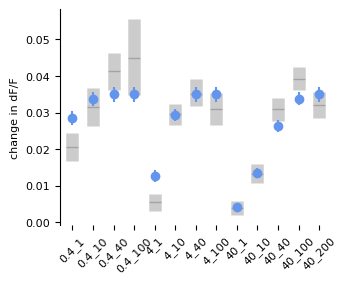

In [12]:
# get the posterior
sim_df = pd.DataFrame()
for condition in conditions:
    depletiontime, pausetime = condition
    condition_name = "{}_{}".format(fm(depletiontime), fm(pausetime))
    sim_df[condition_name] = trace.posterior[condition_name].to_numpy().flatten()

fig = plt.figure(figsize=(3.5,2.8))
ax = fig.subplots(1,1)

# offset points
import matplotlib.transforms as transforms
offset = lambda p: transforms.ScaledTranslation(p/72.,0, fig.dpi_scale_trans)
trans = ax.transData

# remove the right and top and bottom spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

errs_df = df.apply(lambda x: bootstrap_confidence_interval(x), axis=0)
plt.errorbar(df.columns, df.mean(), yerr=errs_df, linestyle='None', marker='None', markersize=2, elinewidth=9, color='black', alpha=0.2)
plt.errorbar(df.columns, df.mean(), yerr=errs_df, linestyle='None', marker='_', markersize=9, elinewidth=0, color='black', alpha=0.2)

errs_sim_df = sim_df.apply(lambda x: percentile_confidence_interval(x), axis=0)
plt.errorbar(sim_df.columns, sim_df.mean(), yerr=sim_df.std(), linestyle='None', marker='o', color='cornflowerblue')

plt.xticks(rotation=45)
plt.ylabel("change in dF/F")

plt.savefig("posterior_only_p_comparison.pdf", bbox_inches='tight')


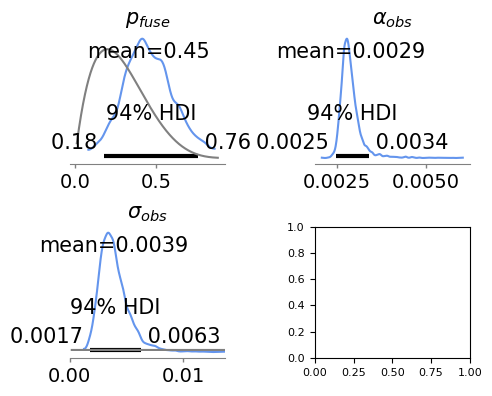

In [9]:
def plot_cont(prior, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    samples = pm.draw(prior, draws=1000)
    x = np.linspace(np.min(samples), np.max(samples), 1000)
    ax.plot(x, np.exp(pm.logp(prior,x)).eval(), color='gray')
    return ax

condition_names = ["{}_{}".format(fm(condition[0]), fm(condition[1])) for condition in conditions]

name_dict = {
    "max_recovery": r"$P^{max}_{recovery}$",
    "max_loaded": r"$P^{max}_{loaded}$",
    "max_docked": r"$P^{max}_{docked}$",
    "max_primed": r"$P^{max}_{primed}$",
    "rate_recover": r"$r_{fused,recovery}$",
    "rate_load": r"$r_{recovery,loaded}$",
    "rate_dock": r"$r_{loaded,docked}$",
    "rate_prime": r"$r_{docked,primed}$",
    "release_probability": r"$p_{fuse}$",
    "observation_factor": r"$\alpha_{obs}$",
    "error_model": r"$\sigma_{obs}$",
}

# for each variable plot prior and posterior
names = [var.name for var in model.unobserved_RVs]
fl = lambda name: not any([condition_name in name for condition_name in condition_names])
names = list(filter(fl, names))

sidelength = int(np.ceil(np.sqrt(len(names))))
fig, axs = plt.subplots(sidelength, sidelength, figsize=(sidelength*2.5, sidelength*2));
axs = axs.flatten()

for name, i in zip(names, range(len(names))):
    ax = axs[i]

    pm.plot_posterior(trace, var_names=name, color='cornflowerblue', ax=ax)
    ax.set_title(name_dict[name], fontdict={'fontsize': 15})
    # plot prior
    prior = model[name]
    try:
        plot_cont(prior, ax=ax)
    except:
        pass
    # scale to posterior
    if name == "error_model":
        ax.set_xlim((0, np.max(trace.posterior[name])))

plt.tight_layout();

plt.savefig("posterior_only_p.pdf", bbox_inches='tight')


In [10]:
print(az.summary(trace))
# keys = list(const_args_var.keys())
# keys = [k.lower() for k in keys]
# az.plot_forest(trace, var_names=keys, combined=True, hdi_prob=0.95, transform=lambda x: np.log10(x))
# az.plot_forest(trace, var_names=["error_model"], combined=True, hdi_prob=0.95)

                             mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
0.4_1                       0.029  0.002   0.025    0.032      0.000    0.000   
0.4_10                      0.034  0.002   0.030    0.037      0.000    0.000   
0.4_100                     0.035  0.002   0.032    0.039      0.000    0.000   
0.4_40                      0.035  0.002   0.032    0.039      0.000    0.000   
40_1                        0.004  0.001   0.004    0.005      0.000    0.000   
40_10                       0.013  0.001   0.012    0.016      0.000    0.000   
40_100                      0.034  0.002   0.030    0.037      0.000    0.000   
40_200                      0.035  0.002   0.032    0.039      0.000    0.000   
40_40                       0.026  0.002   0.024    0.029      0.000    0.000   
4_1                         0.013  0.002   0.011    0.015      0.000    0.000   
4_10                        0.029  0.002   0.026    0.032      0.000    0.000   
4_100                       